#Anomaly Detection Techniques

1. An outlier is an observation with at least one variable having an unusual value.
2. A univariate outlier is an observation with a variable that has an unusual value.
3. A multivariate outlier is an observation with at least two variables having unusual values.

## Possible Techniques:

* DBSCAN
* Isolation Forests (iforest)
* Local Outlier Factor (LOF)
* Elliptic Envelope
* One-Class Support Vector Machines (OCSVM)

https://scikit-learn.org/stable/modules/outlier_detection.html

Dataset is available in Kaggle:
https://www.kaggle.com/akram24/mall-customers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import cm #cmap coloring
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1J25KWxM0cI7CxsHrGVB9DL-4q1GEfhww

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1J25KWxM0cI7CxsHrGVB9DL-4q1GEfhww
To: /content/Mall_Customers.csv
100% 4.29k/4.29k [00:00<00:00, 6.14MB/s]


In [ ]:
#Data Preprocessing:
data = pd.read_csv('Mall_Customers.csv')
data.head()

In [ ]:
data.shape

(200, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
#Dataframe trimming
data=data.drop('CustomerID' ,axis=1)
data=data.rename(columns={'Spending Score (1-100)': 'Score',
                          'Annual Income (k$)': 'Income'})

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   200 non-null    object
 1   Age     200 non-null    int64 
 2   Income  200 non-null    int64 
 3   Score   200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [ ]:
# access to the values of a specifc column
type(data.iloc[:, 0]) #pd.series
type(data.values[:, 0]) #numpy ndarray

In [ ]:
#Normalization
scaler = MinMaxScaler()
normal = scaler.fit_transform(df)
normal_df = pd.DataFrame(normal, columns = df.columns)

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN will output an array of -1’s and 0’s, where -1 indicates an outlier.

In [ ]:
# DBSCAN setup
outlier_detection = DBSCAN(eps=0.3, metric='euclidean',
                           min_samples=5, n_jobs=-1)
clusters = outlier_detection.fit_predict(normal_df)

In [ ]:
for i in range(len(clusters)):
  if clusters[i] != -1:
    clusters[i] = 0

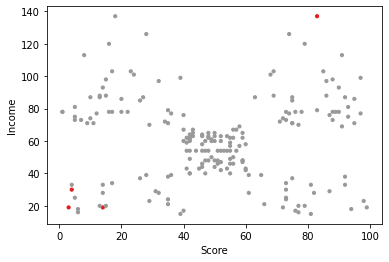

In [ ]:
# Visualize DBSCAN output
cmap = cm.get_cmap('Set1')
df.plot.scatter(x='Score', y='Income', c=clusters,
                  cmap=cmap, s=10, colorbar = False);

### Isolation Forests

`class sklearn.ensemble.IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)`

**n_estimatorsint:** default=100
The number of base estimators in the ensemble.

**max_samples:** The number of samples to draw from X to train each base estimator.

**contamination:** the proportion of outliers in the data set.

**warm_startbool:** When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [ ]:
rs=np.random.RandomState(42)
ifor = IsolationForest(max_samples=25, n_estimators=50,
                      random_state=rs, contamination=.1,
                      warm_start=True)
ifor.fit(normal_df)
if_anomalies = ifor.predict(normal_df)
if_anomalies = pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies = normal_df[if_anomalies==1];

Text(0.5, 1.0, 'Isolation Forests - Anomalies')

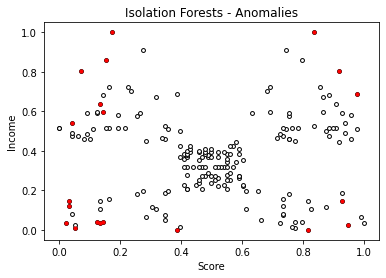

In [ ]:
cmap = np.array(['white','red'])
plt.scatter(normal_df.iloc[:,2], normal_df.iloc[:,1], c='white', s=15, edgecolor='k')
plt.scatter(if_anomalies.iloc[:,2], if_anomalies.iloc[:,1], s=10, c='red')
plt.xlabel('Score')
plt.ylabel('Income')
plt.title('Isolation Forests - Anomalies')

### Local Outlier Factor
LOF uses density-based outlier detection to identify local outliers, points that are outliers with respect to their local neighborhood, rather than with respect to the global data distribution. The higher the LOF value for an observation, the more anomalous the observation.

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html

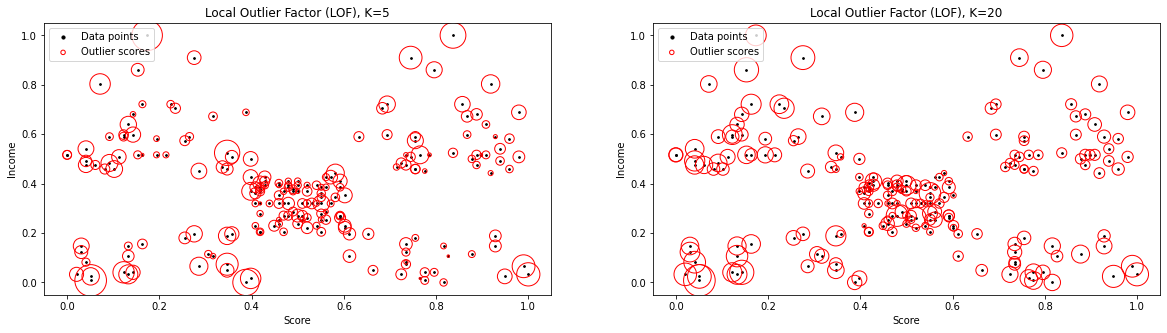

In [ ]:
def LOF_plot(k):
  var1, var2 = 1, 2
  LOF = LocalOutlierFactor(n_neighbors=k, contamination=.1)
  y_pred = LOF.fit_predict(normal_df)
  LOF_Scores = LOF.negative_outlier_factor_

  plt.title('Local Outlier Factor (LOF), K={}'.format(k))
  plt.scatter(normal_df.iloc[:, var2], normal_df.iloc[:, var1], color='k', s=3., label='Data points')
  radius = (LOF_Scores.max() - LOF_Scores) / (LOF_Scores.max() - LOF_Scores.min())
  plt.scatter(normal_df.iloc[:, var2], normal_df.iloc[:, var1], s=1000 * radius, edgecolors='r',
  facecolors='none', label='Outlier scores')
  plt.axis('tight')
  plt.ylabel('{}'.format(normal_df.columns[var1]))
  plt.xlabel('{}'.format(normal_df.columns[var2]))
  legend = plt.legend(loc='upper left')
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
LOF_plot(5)
plt.subplot(1, 2, 2)
LOF_plot(20)
plt.show()

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
LOF2 = LocalOutlierFactor(n_neighbors=20, contamination=.1)
y_pred = LOF2.fit_predict(normal_df)
LOF_Scores = LOF2.negative_outlier_factor_
LOF_pred = pd.Series(y_pred).replace([-1,1],[1,0])
LOF_anomalies = normal_df[LOF_pred==1]

Text(0, 0.5, 'Income')

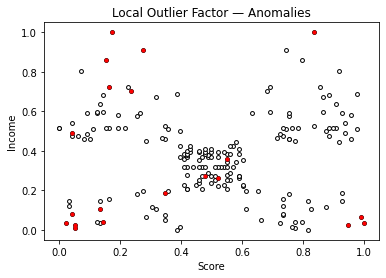

In [ ]:
cmap=np.array(['white','red'])
plt.scatter(normal_df.iloc[:,2], normal_df.iloc[:,1], c='white', s=15, edgecolor='k')
plt.scatter(LOF_anomalies.iloc[:,2], LOF_anomalies.iloc[:,1], s=10, c='red')
 #,marker=’x’,s=100)
plt.title('Local Outlier Factor — Anomalies')
plt.xlabel('Score')
plt.ylabel('Income')

### Elliptic Envelope
The Elliptic Envelope method fits a multivariate gaussian distribution to the dataset. Use the contamination hyperparameter to specify the percentage of observations the algorithm will assign as outliers.

https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html

In [ ]:
EE = EllipticEnvelope(contamination=.1,random_state=0)
EE.fit(normal_df)
ee_scores = pd.Series(EE.decision_function(normal_df))
ee_predict = EE.predict(normal_df)
EE_pred = pd.Series(ee_predict).replace([-1,1],[1,0])
EE_anomalies = normal_df[EE_pred==1]

Text(0, 0.5, 'Spend_Score')

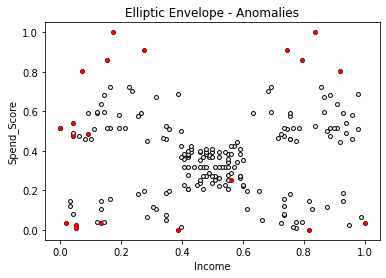

In [ ]:
cmap=np.array(['white','red'])
plt.scatter(normal_df.iloc[:,2], normal_df.iloc[:,1], c='white', s=15, edgecolor='k')
plt.scatter(EE_anomalies.iloc[:,2], EE_anomalies.iloc[:,1], s=10, c='red')
plt.title('Elliptic Envelope - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')

### One-Class SVM (OCSVM)
Unlike the regular supervised SVM, the one-class SVM does not have target labels for the model training process. Instead, it learns the boundary for the normal data points and identifies the data outside the border to be anomalies.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

In [ ]:
# Train the one class support vector machine (SVM) model
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto').fit(normal_df)

In [ ]:
# Predict the anomalies
ocsvm_pred = ocsvm.predict(normal_df)
# Change the anomalies' values to make it consistent with the true values
ocsvm_pred = pd.Series(ocsvm_pred).replace([-1,1],[1,0])
ocsvm_anomalies = normal_df[ocsvm_pred==1]

Text(0, 0.5, 'Spend_Score')

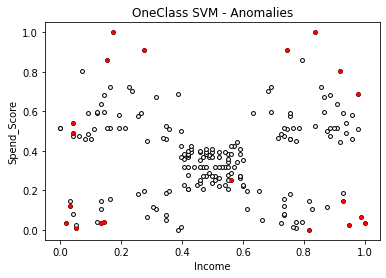

In [ ]:
cmap=np.array(['white','red'])
plt.scatter(normal_df.iloc[:,2], normal_df.iloc[:,1], c='white', s=15, edgecolor='k')
plt.scatter(ocsvm_anomalies.iloc[:,2], ocsvm_anomalies.iloc[:,1], s=10, c='red')
plt.title('OneClass SVM - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')